# Лабораторная работа №4. Регрессионный анализ данных

## Ковалев Егор 19-ИВТ-3
## Вариант 9
### Цель лабораторной работы – получение навыков работы с методами регрессии
Задания:

1.	Изучить набор данных. Создать описание набора данных на русском языке. Описать признаки, используемые в наборе данных (включить полученные описания в отчёт).
2.	Удалите дубликаты строк в наборе данных; приведите размер набора данных до и после данной операции;
3.	Выполните масштабирование количественных признаков; Постройте диаграммы BoxPlot для признаков до и после масштабирования. Выберите способ масштабирования (например, нормализацию или стандартизацию);
4.	Выполните замену категориальных признаков; выберите и обоснуйте способ замены;
5.	Оцените корреляцию между признаков и удалите те признаки, которые коррелируют с наибольшим числом других;
6.	Заполните пропущенные значения в данных;
7.	Решите поставленную задачу регрессии в соответствии с заданием. При подборе параметров метода принятия решения (метода регрессии) используйте перекрёстную проверку (изучите возможные для изменения параметры метода регрессии).  Вычислите точность решения задачи, вычислив разницу между реальным значением и предсказанным. Вычислите коэффициент корреляции (Пирсона, Спирмена) между реальным значением и предсказанным с учётом p-value. 



In [1]:
import numpy as np
import pandas as pd
import sklearn as sk
import seaborn as sn
import matplotlib.pyplot as plt

from pylab import rcParams
from scipy import interp
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.neighbors import RadiusNeighborsClassifier
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import (auc, roc_curve, 
                             precision_recall_curve, 
                             average_precision_score)
from sklearn.multiclass import OneVsRestClassifier
from sklearn import svm
from sklearn.preprocessing import label_binarize
from sklearn.preprocessing import StandardScaler

%matplotlib inline

In [2]:
df_house = pd.read_csv("kc_house_data.csv")
df_house

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,20141013T000000,221900.0,3,1.00,1180,5650,1.0,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,6414100192,20141209T000000,538000.0,3,2.25,2570,7242,2.0,0,0,...,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639
2,5631500400,20150225T000000,180000.0,2,1.00,770,10000,1.0,0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
3,2487200875,20141209T000000,604000.0,4,3.00,1960,5000,1.0,0,0,...,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000
4,1954400510,20150218T000000,510000.0,3,2.00,1680,8080,1.0,0,0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21608,263000018,20140521T000000,360000.0,3,2.50,1530,1131,3.0,0,0,...,8,1530,0,2009,0,98103,47.6993,-122.346,1530,1509
21609,6600060120,20150223T000000,400000.0,4,2.50,2310,5813,2.0,0,0,...,8,2310,0,2014,0,98146,47.5107,-122.362,1830,7200
21610,1523300141,20140623T000000,402101.0,2,0.75,1020,1350,2.0,0,0,...,7,1020,0,2009,0,98144,47.5944,-122.299,1020,2007
21611,291310100,20150116T000000,400000.0,3,2.50,1600,2388,2.0,0,0,...,8,1600,0,2004,0,98027,47.5345,-122.069,1410,1287


## Задание 1

Этот набор данных содержит цены продажи домов в округе Кинг, включая Сиэтл. Он включает в себя дома, проданные в период с мая 2014 по май 2015 года.

Это отличный набор данных для оценки простых регрессионных моделей.

    id - Уникальный идентификатор для каждого проданного дома
    дата - Дата продажи дома
    цена - Цена каждого проданного дома
    спальни - Количество спален
    ванные комнаты - Количество ванных комнат, где .5 приходится на комнату с туалетом, но без душа
    sqft_living - Квадратные метры квартир внутренняя жилая площадь
    sqft_lot - Квадратные метры земельных площадей
    этажи - Количество этажей
    прибрежный - фиктивная переменная, находится ли квартира была с видом на набережную или нет
    вид - индекс от 0 до 4 насколько хорош тот или иной вид имущества
    состояние - индекс от 1 до 5 при условии, квартиры,
    класс - индекс от 1 до 13, где 1-3 дотягивает строительства и дизайна, 7 имеет средний уровень проектирования и строительства, и 11-13 имеют высокий уровень качества строительства и дизайна.
    sqft_above - Площадь внутреннего жилого пространства, находящегося над уровнем земли
    sqft_basement - Площадь внутреннего жилого пространства, которое находится ниже уровня
    земли yr_built - Год, когда дом был первоначально построен
    yr_renovated - Год последней реконструкции дома
    zipcode - Какая площадь zipcode находится в доме
    lat - Lattitude
    long - Longitude
    sqft_living15 - Площадь внутреннего жилого пространства для ближайших 15 соседей
    sqft_lot15 - Площадь земельных участков ближайших 15 соседей

## Задание 2

In [3]:
print("Number of rows before deleting clones: ", df_house.shape[0])

Number of rows before deleting clones:  21613


In [4]:
df_house.drop_duplicates(keep = 'first', inplace = True)

In [5]:
print("Number of rows after deleting clones: ", df_house.shape[0])

Number of rows after deleting clones:  21613


## Задание 3

In [6]:
rcParams["figure.figsize"]=10, 7

(array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
        18, 19, 20]),
 [Text(1, 0, 'id'),
  Text(2, 0, 'price'),
  Text(3, 0, 'bedrooms'),
  Text(4, 0, 'bathrooms'),
  Text(5, 0, 'sqft_living'),
  Text(6, 0, 'sqft_lot'),
  Text(7, 0, 'floors'),
  Text(8, 0, 'waterfront'),
  Text(9, 0, 'view'),
  Text(10, 0, 'condition'),
  Text(11, 0, 'grade'),
  Text(12, 0, 'sqft_above'),
  Text(13, 0, 'sqft_basement'),
  Text(14, 0, 'yr_built'),
  Text(15, 0, 'yr_renovated'),
  Text(16, 0, 'zipcode'),
  Text(17, 0, 'lat'),
  Text(18, 0, 'long'),
  Text(19, 0, 'sqft_living15'),
  Text(20, 0, 'sqft_lot15')])

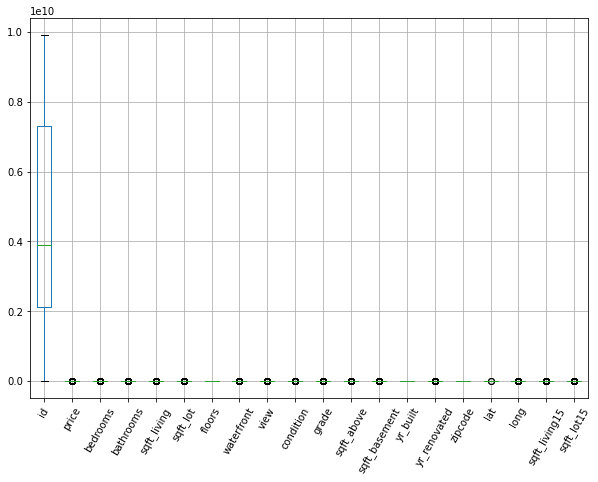

In [7]:
df_house.boxplot()
plt.xticks(rotation=60)

In [8]:
numerical = []
for i in df_house.columns:
    if (df_house[i].dtype == np.float64 or df_house[i].dtype == np.int64):
        numerical.append(df_house[i].name)
numerical = numerical[2:]
numerical

['bedrooms',
 'bathrooms',
 'sqft_living',
 'sqft_lot',
 'floors',
 'waterfront',
 'view',
 'condition',
 'grade',
 'sqft_above',
 'sqft_basement',
 'yr_built',
 'yr_renovated',
 'zipcode',
 'lat',
 'long',
 'sqft_living15',
 'sqft_lot15']

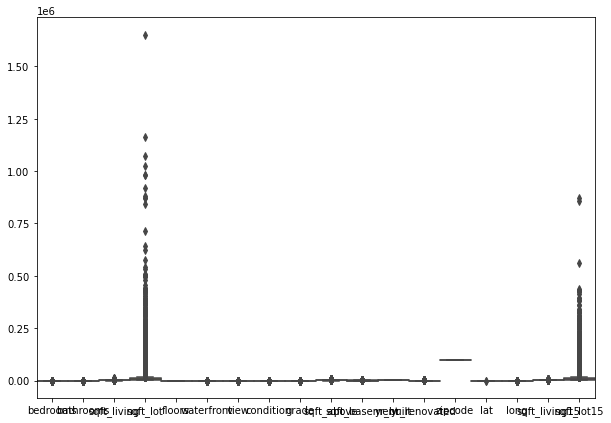

In [9]:
sn.boxplot(data = df_house[numerical], width=1, orient = 'v')
plt.show()

<AxesSubplot:>

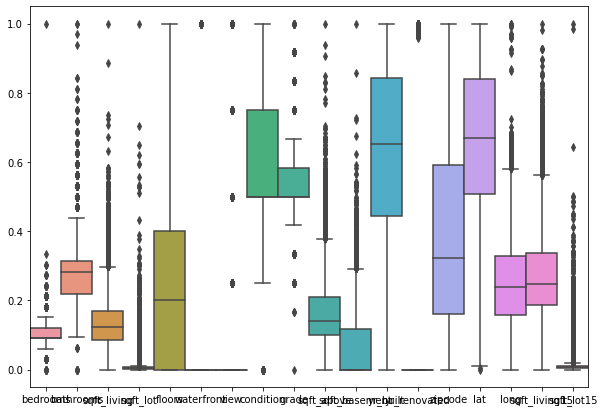

In [10]:
# Нормализация
scaler = MinMaxScaler()
df_house[numerical] = scaler.fit_transform(df_house[numerical].values.astype(float))
sn.boxplot(data = df_house[numerical], width=1, orient = 'v')

## Задание 4

In [11]:
categorical = ['id']
for i in df_house.columns:
    if (df_house[i].dtype != np.float64 and df_house[i].dtype != np.int64):
        categorical.append(df_house[i].name)
categorical

['id', 'date']

In [12]:
encoder = LabelEncoder()
for i in categorical:
    df_house[i] = encoder.fit_transform(df_house[i])
df_house

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,15339,164,221900.0,0.090909,0.12500,0.067170,0.003108,0.0,0.0,0.0,...,0.500000,0.097588,0.000000,0.478261,0.000000,0.893939,0.571498,0.217608,0.161934,0.005742
1,14466,220,538000.0,0.090909,0.28125,0.172075,0.004072,0.4,0.0,0.0,...,0.500000,0.206140,0.082988,0.443478,0.988089,0.626263,0.908959,0.166113,0.222165,0.008027
2,13503,290,180000.0,0.060606,0.12500,0.036226,0.005743,0.0,0.0,0.0,...,0.416667,0.052632,0.000000,0.286957,0.000000,0.136364,0.936143,0.237542,0.399415,0.008513
3,6371,220,604000.0,0.121212,0.37500,0.126038,0.002714,0.0,0.0,0.0,...,0.500000,0.083333,0.188797,0.565217,0.000000,0.681818,0.586939,0.104651,0.165376,0.004996
4,4955,283,510000.0,0.090909,0.25000,0.104906,0.004579,0.0,0.0,0.0,...,0.583333,0.152412,0.000000,0.756522,0.000000,0.368687,0.741354,0.393688,0.241094,0.007871
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21608,574,19,360000.0,0.090909,0.31250,0.093585,0.000370,0.8,0.0,0.0,...,0.583333,0.135965,0.000000,0.947826,0.000000,0.515152,0.874055,0.143688,0.194631,0.000986
21609,14564,288,400000.0,0.121212,0.31250,0.152453,0.003206,0.4,0.0,0.0,...,0.583333,0.221491,0.000000,0.991304,0.000000,0.732323,0.570693,0.130399,0.246257,0.007523
21610,3621,52,402101.0,0.060606,0.09375,0.055094,0.000503,0.4,0.0,0.0,...,0.500000,0.080044,0.000000,0.947826,0.000000,0.722222,0.705324,0.182724,0.106866,0.001558
21611,629,252,400000.0,0.090909,0.31250,0.098868,0.001132,0.4,0.0,0.0,...,0.583333,0.143640,0.000000,0.904348,0.000000,0.131313,0.608975,0.373754,0.173980,0.000731


## Задание 5

id              -0.016534
date            -0.004649
price            1.000000
bedrooms         0.308350
bathrooms        0.525138
sqft_living      0.702035
sqft_lot         0.089661
floors           0.256794
waterfront       0.266369
view             0.397293
condition        0.036362
grade            0.667434
sqft_above       0.605567
sqft_basement    0.323816
yr_built         0.054012
yr_renovated     0.126434
zipcode         -0.053203
lat              0.307003
long             0.021626
sqft_living15    0.585379
sqft_lot15       0.082447
Name: price, dtype: float64

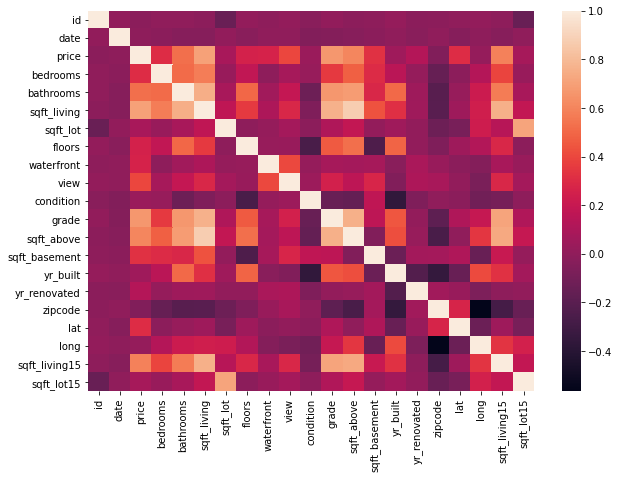

In [13]:
sn.heatmap(df_house.corr())
df_house.corr()['price']

In [14]:
for name, val in zip(df_house.columns, df_house.corr()['price']):
    print(f"{name:<30}: ", end='')
    print(f'{val:>10.6f}') if abs(val) > 0.25 else print('weak corr!!!')

id                            : weak corr!!!
date                          : weak corr!!!
price                         :   1.000000
bedrooms                      :   0.308350
bathrooms                     :   0.525138
sqft_living                   :   0.702035
sqft_lot                      : weak corr!!!
floors                        :   0.256794
waterfront                    :   0.266369
view                          :   0.397293
condition                     : weak corr!!!
grade                         :   0.667434
sqft_above                    :   0.605567
sqft_basement                 :   0.323816
yr_built                      : weak corr!!!
yr_renovated                  : weak corr!!!
zipcode                       : weak corr!!!
lat                           :   0.307003
long                          : weak corr!!!
sqft_living15                 :   0.585379
sqft_lot15                    : weak corr!!!


In [15]:
cols = []
for name, val in zip(df_house.columns, df_house.corr()['price']):
    print(f"{name:<30}: ", end='')
    print(f'{val:>10.6f}') if abs(val) < 0.25 else print('strong corr!!!')
    
    cols.append(name) if abs(val) < 0.25 else ""
#cols=cols[1:]
print(cols)

id                            :  -0.016534
date                          :  -0.004649
price                         : strong corr!!!
bedrooms                      : strong corr!!!
bathrooms                     : strong corr!!!
sqft_living                   : strong corr!!!
sqft_lot                      :   0.089661
floors                        : strong corr!!!
waterfront                    : strong corr!!!
view                          : strong corr!!!
condition                     :   0.036362
grade                         : strong corr!!!
sqft_above                    : strong corr!!!
sqft_basement                 : strong corr!!!
yr_built                      :   0.054012
yr_renovated                  :   0.126434
zipcode                       :  -0.053203
lat                           : strong corr!!!
long                          :   0.021626
sqft_living15                 : strong corr!!!
sqft_lot15                    :   0.082447
['id', 'date', 'sqft_lot', 'condition', 'yr_built

In [16]:
df_house.drop(cols, axis=1, inplace=True)
df_house

,price,bedrooms,bathrooms,sqft_living,floors,waterfront,view,grade,sqft_above,sqft_basement,lat,sqft_living15
0,221900.0,0.090909,0.12500,0.067170,0.0,0.0,0.0,0.500000,0.097588,0.000000,0.571498,0.161934
1,538000.0,0.090909,0.28125,0.172075,0.4,0.0,0.0,0.500000,0.206140,0.082988,0.908959,0.222165
2,180000.0,0.060606,0.12500,0.036226,0.0,0.0,0.0,0.416667,0.052632,0.000000,0.936143,0.399415
3,604000.0,0.121212,0.37500,0.126038,0.0,0.0,0.0,0.500000,0.083333,0.188797,0.586939,0.165376
4,510000.0,0.090909,0.25000,0.104906,0.0,0.0,0.0,0.583333,0.152412,0.000000,0.741354,0.241094
...,...,...,...,...,...,...,...,...,...,...,...,...
21608,360000.0,0.090909,0.31250,0.093585,0.8,0.0,0.0,0.583333,0.135965,0.000000,0.874055,0.194631
21609,400000.0,0.121212,0.31250,0.152453,0.4,0.0,0.0,0.583333,0.221491,0.000000,0.570693,0.246257
21610,402101.0,0.060606,0.09375,0.055094,0.4,0.0,0.0,0.500000,0.080044,0.000000,0.705324,0.106866
21611,400000.0,0.090909,0.31250,0.098868,0.4,0.0,0.0,0.583333,0.143640,0.000000,0.608975,0.173980


## Задание 6

In [17]:
df_house.isna().sum()

price            0
bedrooms         0
bathrooms        0
sqft_living      0
floors           0
waterfront       0
view             0
grade            0
sqft_above       0
sqft_basement    0
lat              0
sqft_living15    0
dtype: int64

## Задание 7

In [18]:
from  sklearn import linear_model
# линейная регрессия, LASSO регуляризатор.
X, y = df_house.drop(['price'], axis=1), df_house['price']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 123)

reg = linear_model.Lasso (alpha = 0.1)
reg.fit (X_train, y_train)

F:\WinPython\WPy64-3870\python-3.8.7.amd64\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 167442564649777.6, tolerance: 203235081382.9628
  model = cd_fast.enet_coordinate_descent(


Lasso(alpha=0.1)

In [19]:
reg.coef_

array([-785502.90644833,  -50318.18009765, 3777912.81426837,
        -81580.85565107,  647047.21665007,  265237.47060461,
       1039244.18786881, -846932.26249688, -455021.41157276,
        421550.36831476,   11468.60426463])

In [20]:
xt = reg.predict(X_test)
print(xt[:10])

[ 617138.50800786  486228.81089753  999351.70613512 1161860.17627272
  297906.40269078  218101.00368056  661531.68499286  426083.44681623
  690978.84325228  731186.23032607]


In [21]:
print(y_test[:10])

5506     532500.0
9279     410000.0
16034    782500.0
6608     995000.0
20359    279000.0
8798     175000.0
10035    689000.0
13321    275000.0
15842    465000.0
12119    506000.0
Name: price, dtype: float64


In [22]:
print(xt[:10]-y_test[:10])

5506      84638.508008
9279      76228.810898
16034    216851.706135
6608     166860.176273
20359     18906.402691
8798      43101.003681
10035    -27468.315007
13321    151083.446816
15842    225978.843252
12119    225186.230326
Name: price, dtype: float64


In [23]:
reg.intercept_

-567643.1744641074

In [24]:
from  sklearn import linear_model
# линейная регрессия без использования регуляризаторов;

X, y = df_house.drop(['price'], axis=1), df_house['price']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 123)

reg = linear_model.LinearRegression()

reg.fit(X_train,y_train)

LinearRegression()

In [25]:
reg.coef_

array([-785652.96904846,  -50293.28919456,  959642.61718094,
        -81589.46299167,  647060.76138152,  265232.64272675,
       1039217.74931489, 1092875.08475049,  570175.0839674 ,
        421553.49219836,   11508.78073303])

In [26]:
reg.intercept_

-567627.7515628281

In [27]:
from scipy.stats import *
corr={}
corr['pearson'], _ = stats.pearsonr(xt,y_test)
corr['spearman'], _ = stats.spearmanr(xt,y_test)
print(corr['pearson'])
print(corr['spearman'])

0.8186107179472711
0.839618444840542
